In [11]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gsn.perform_gsn import perform_gsn

from scipy.ndimage import gaussian_filter1d, uniform_filter1d

# raw: (units, time, images, trials)
def psth_gaussian(raw, sigma=3):
    # smooth along the time axis
    psth = gaussian_filter1d(raw, sigma=sigma, axis=1)
    return psth

def psth_window(raw, window_ms=50):
    # raw: (units, time, images, trials)
    # convert NaN to 0 so windowing behaves properly
    X = np.nan_to_num(raw, nan=0.0)
    # sliding window average over time axis
    psth = uniform_filter1d(X, size=window_ms, axis=1, mode='constant')
    return psth

def summary(x):
    print(f'''Summary statistics {x.shape}:
    \tMedian: {np.nanmedian(x)}
    \tMean: {np.nanmean(x)}
    \tMinimum: {np.nanmin(x)}
    \tMaximum:{np.nanmax(x)}\n''')

def segregate(df, method='truncate'):
    roi_arrays = {}
    for roi, df_roi in df.groupby('roi'):
        arrays = df_roi['raster'].to_list()
        if method == 'truncate':
            # count valid trials per unit
            valid_counts = []
            valid_masks  = []

            # minimum trials with no NaNs
            for a in arrays:
                vm = ~np.isnan(a).any(axis=(0,1))
                valid_masks.append(vm)
                valid_counts.append(vm.sum())
            min_T = min(valid_counts)
        
            total = []
            for a, vm in zip(arrays, valid_masks):
                idx = np.where(vm)[0][:min_T]   # first min_T valid trials
                total.append(a[:, :, idx])
        elif method == 'pad':
            # find max number of trials *within this ROI*
            max_T = max(a.shape[2] for a in arrays)
            total = []
            for a in arrays:
                T = a.shape[2]
                if T < max_T:
                    pad_width = ((0, 0), (0, 0), (0, max_T - T))
                    a = np.pad(a, pad_width, constant_values=np.nan)
                total.append(a)

        x_roi = np.array(total)   # (units, 450, 1072, min_T)
        roi_arrays[roi] = x_roi
        print(roi, x_roi.shape)

    return roi_arrays

In [8]:
ras_df = pd.read_pickle('../../datasets/NNN/raw_raster_data_batch000.pkl')
print(f'Succesfully loaded data for {len(ras_df)} units.')

roi_arrays = segregate(ras_df, method='truncate')

Succesfully loaded data for 608 units.
Unknown_19_F (608, 450, 1072, 5)


Summary statistics (608, 450, 1072, 5):
    
	Median: 0.0
    
	Mean: 0.004250311845378371
    
	Minimum: 0.0
    
	Maximum:0.46

Summary statistics (608, 450, 1072, 5):
    
	Median: 0.0
    
	Mean: 0.009239808359518199
    
	Minimum: 0.0
    
	Maximum:1.0

(608, 450, 1072, 5)
(608, 450)
Estimating noise covariance...done.
Estimating data covariance...done.
Estimating signal covariance...done.
Performing biconvex optimization...done.
done.


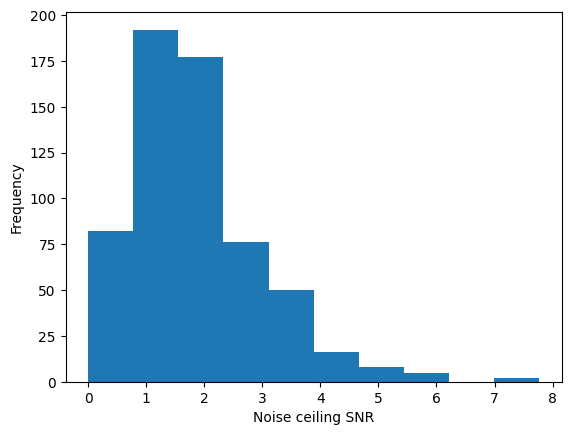

1.0
1.0


In [9]:
ROI = 'Unknown_19_F'
x = roi_arrays[ROI] # shape: (608, 450, 1072, reps)
psth = psth_window(x, window_ms=50)
summary(psth)

normed = psth / np.max(psth)
summary(normed)
print(normed.shape)

# average over images
img_avg = np.mean(normed, axis=2)
# average over trials
img_avg_g = np.mean(img_avg, axis=2)
print(img_avg_g.shape)
# xt = x
# out = xt / np.nanmax(xt)
# # summary(out)
# # print(out.shape)
# psth = psth_window(out, window_ms=50)

# Perform GSN.
# We explicitly set the wantshrinkage flag to true.
results = perform_gsn(img_avg, {'wantshrinkage': True})

# Let's take a look at ncsnr
plt.figure()
plt.hist(results['ncsnr'])
plt.xlabel('Noise ceiling SNR')
plt.ylabel('Frequency')
plt.show()

# Notice that the data covariance estimate involved some shrinkage:
print(results['shrinklevelD'])

# Notice that the noise covariance estimate in this case did not involve shrinkage:
print(results['shrinklevelN'])

# # sns.heatmap(results['cSb'], vmax=np.max(results['cSb']), vmin=np.min(results['cSb']))
# sns.heatmap(results['cSb'], vmax=0.000005, vmin=0)
# summary(results['cSb'])

In [ ]:
# Set range for color limits
rng = [np.nanmin(results['cSb']), np.nanmax(results['cSb'])]

# Visualize the covariance estimates
plt.figure(figsize=(10, 8))

# Noise covariance estimate
plt.subplot(2, 2, 1)
plt.imshow(results['cN'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('cN')
plt.axis('tight')

# Final noise covariance estimate
plt.subplot(2, 2, 2)
plt.imshow(results['cNb'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('cNb')
plt.axis('tight')

# Signal covariance estimate
plt.subplot(2, 2, 3)
plt.imshow(results['cS'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('cS')
plt.axis('tight')

# Final signal covariance estimate
plt.subplot(2, 2, 4)
plt.imshow(results['cSb'], vmin=rng[0], vmax=rng[1], aspect='auto', interpolation='none')
plt.colorbar()
plt.title('cSb')
plt.axis('tight')

plt.show()